In [1]:
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import os, sys

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

import warnings
warnings.filterwarnings("ignore")


In [3]:
working_directory = os.getcwd()
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.drop(columns={"CustomerId"}, inplace=True)
test_df.drop(columns={"CustomerId"}, inplace=True)

train_df.drop(columns={"Surname"}, inplace=True)
test_df.drop(columns={"Surname"}, inplace=True)

# Changing the data type of id
train_df.id = train_df.id.astype("category")
test_df.id = test_df.id.astype("category")

In [5]:
def get_features(table):
    df = table.copy()
    df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})
    df['Gender'] = df['Gender'].astype('uint8')
    # create dummy variables for categorical features
    geo_dummies = pd.get_dummies(df.Geography, prefix="geo")
    prod_dummies = pd.get_dummies(df.NumOfProducts, prefix="prod")
    # concatenate dummy columns with main dataset
    table_dummies = pd.concat([df, geo_dummies, prod_dummies], axis=1)

    # drop categorical fields
    table_dummies.drop(['id','Geography', 'NumOfProducts'], axis=1, inplace=True)
    return table_dummies

In [6]:
train = get_features(train_df)

x_train = train.drop('Exited', axis=1) 
y_train = train['Exited']

In [7]:
def get_roc(y, predict_vals, prob_values):
  roc_score = metrics.roc_auc_score(y, predict_vals)
  false_positives, true_positives, _ = metrics.roc_curve(y, prob_values)
  return (roc_score, false_positives, true_positives)

In [ ]:
xgb = XGBClassifier()

for i in range(30,130,8):
    print(f"running iteration for random state - {i}")
    train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size = 0.2, random_state = i)
    xgb.fit(train_x, train_y)
    print('XGBoost Classifier Training Accuracy {}: Validation Accuracy {}'.format(xgb.score(train_x, train_y), xgb.score(test_x,test_y)))
    roc_xgb, false_xgb, true_xgb = get_roc(test_y, xgb.predict(test_x), xgb.predict_proba(test_x)[:, 1])
    print(f"ROC AUC - {roc_xgb}")
    print("*"*100)


In [8]:
state = 118
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size = 0.2, random_state = state)
base_xgb = XGBClassifier()
base_xgb.fit(train_x, train_y)
print('XGBoost Classifier Training Accuracy {}: Validation Accuracy {}'.format(base_xgb.score(train_x, train_y), base_xgb.score(test_x,test_y)))
roc_xgb, false_xgb, true_xgb = get_roc(test_y, base_xgb.predict(test_x), base_xgb.predict_proba(test_x)[:, 1])
print(f"ROC AUC - {roc_xgb}")

XGBoost Classifier Training Accuracy 0.8805547350163224: Validation Accuracy 0.8666343502893326
ROC AUC - 0.7571487982068429


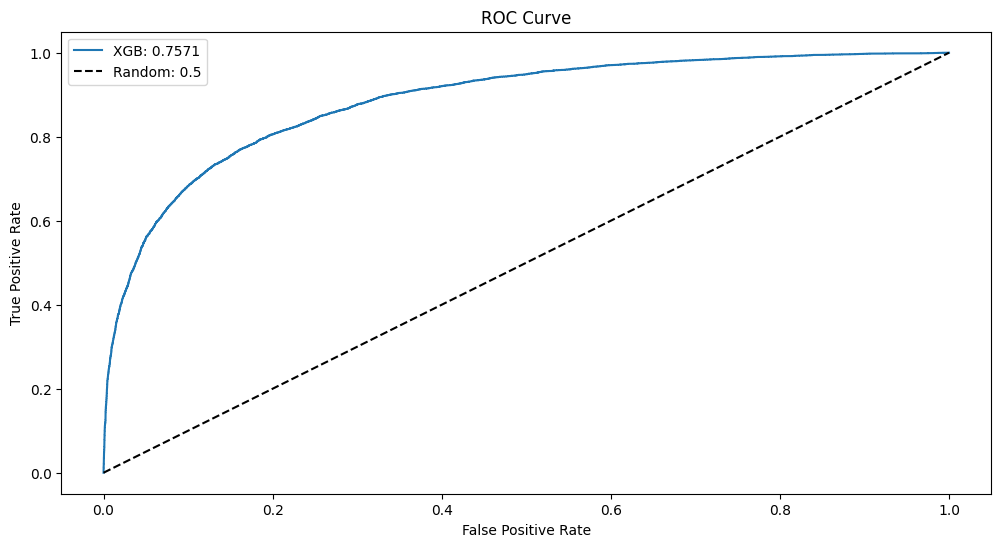

In [9]:
plt.figure(figsize = (12,6), linewidth = 2)

plt.plot(false_xgb, true_xgb, label = 'XGB: ' + str(round(roc_xgb, 4)))


plt.plot([0, 1], [0, 1], 'k--', label = 'Random: 0.5')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

In [10]:
importances = pd.DataFrame({'feature':train_x.columns,'importance':np.round(base_xgb.feature_importances_,3)*100})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.reset_index()

,feature,importance
0,prod_2,70.700005
1,IsActiveMember,7.700000
2,prod_1,7.400000
3,Age,4.100000
4,geo_Germany,4.000000
5,Gender,1.600000
6,Balance,1.100000
7,prod_3,0.700000
8,HasCrCard,0.500000
9,CreditScore,0.400000


In [11]:
train_x.head()

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,geo_France,geo_Germany,geo_Spain,prod_1,prod_2,prod_3,prod_4
49465,646,1,44.0,1,0.00,1.0,0.0,17439.66,1,0,0,0,1,0,0
5483,538,1,59.0,0,0.00,0.0,0.0,179453.66,0,0,1,0,1,0,0
21203,714,0,42.0,1,0.00,1.0,0.0,152167.79,1,0,0,1,0,0,0
46047,807,1,43.0,0,0.00,1.0,1.0,85523.24,0,0,1,0,1,0,0
109262,659,0,38.0,2,124098.54,1.0,0.0,166698.18,0,1,0,0,1,0,0


In [12]:
num_columns = x_train.select_dtypes(include='number').columns.tolist()
cat_columns = x_train.select_dtypes(include='object').columns.tolist()

In [13]:
num_features = [] 

for i in num_columns:
    location = x_train.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [14]:
cat_features = []

for i in cat_columns:
    location = x_train.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[]


In [15]:
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [])])

In [16]:
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=state),
                  XGBClassifier(use_label_encoder=False, random_state=state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [])])),
                ('smote', SMOTE(random_state=118)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsam...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=118, ...))])

In [17]:
XGBClassifier().get_params()


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'xgbclassifier__gamma': [0.5, 0.8, 1],
              'xgbclassifier__max_depth': [3, 4, 5, 6],
              'xgbclassifier__n_estimators': [50, 100, 200]
        }
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='f1_macro')

In [19]:
grid.fit(train_x, train_y, xgbclassifier__eval_metric='logloss')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.775 total time=   4.5s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.772 total time=   5.1s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.770 total time=   5.1s
[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.776 total time=   5.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.777 total time=   4.3s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.784 total time=   5.1s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.781 total time=   5.2s
[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.787 total time=   5.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.779 total time=   5.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.786 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.785 total time=   6.7s
[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.788 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.783 total time=   7.1s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.780 total time=   6.8s
[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.786 total time=   5.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.780 total time=   5.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.782 total time=   6.3s
[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.783 total time=   5.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.779 total time=   6.3s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.778 total time=   7.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.788 total time=   5.9s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.783 total time=   5.8s
[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.785 total time=   7.2s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.779 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.785 total time=   4.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.784 total time=   7.0s
[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.786 total time=   6.4s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.782 total time=   7.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.780 total time=   7.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.784 total time=   6.5s
[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.783 total time=   6.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.785 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.779 total time=   5.3s
[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.783 total time=   4.5s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.779 total time=   5.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.785 total time=   6.3s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.786 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.780 total time=   7.0s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.778 total time=   7.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.784 total time=   6.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.785 total time=   6.9s
[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.786 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.779 total time=   7.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.778 total time=   7.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.784 total time=   5.1s
[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.781 total time=   7.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.786 total time=   6.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.779 total time=   5.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.783 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.784 total time=   4.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.780 total time=   5.6s
[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.783 total time=   5.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.779 total time=   5.5s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.779 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.783 total time=   5.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.780 total time=   6.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.784 total time=   8.0s
[CV 4/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.778 total time=   6.6s
[CV 3/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.777 total time=   8.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.5, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.781 total time=   6.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.776 total time=   5.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.775 total time=   4.8s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.770 total time=   5.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.777 total time=   3.8s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.772 total time=   5.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.784 total time=   5.0s
[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.787 total time=   4.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.781 total time=   5.1s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.786 total time=   3.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.779 total time=   6.4s
[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.785 total time=   5.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.787 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.782 total time=   6.5s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.786 total time=   5.5s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.780 total time=   6.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.780 total time=   6.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.782 total time=   6.3s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.779 total time=   6.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.779 total time=   6.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.783 total time=   4.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.784 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.788 total time=   6.7s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.783 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.779 total time=   6.1s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.785 total time=   4.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.784 total time=   7.5s
[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.787 total time=   7.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.782 total time=   7.9s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.779 total time=   8.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.784 total time=   7.1s
[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.783 total time=   7.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.784 total time=   7.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.780 total time=   7.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.786 total time=   4.7s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.778 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.785 total time=   6.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.786 total time=   5.9s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.779 total time=   5.5s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.780 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.785 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.784 total time=   6.7s
[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.786 total time=   7.3s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.780 total time=   7.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.785 total time=   5.6s
[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.783 total time=   6.6s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.779 total time=  10.0s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.783 total time=   9.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.782 total time=   7.6s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.784 total time=   6.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.779 total time=   8.0s
[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.781 total time=   8.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.784 total time=   8.8s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.780 total time=   9.2s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.782 total time=   6.9s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.778 total time=   8.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.781 total time=   8.2s
[CV 4/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.778 total time=   7.5s
[CV 2/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.784 total time=   8.2s
[CV 3/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.780 total time=   8.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.776 total time=   5.7s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.775 total time=   5.8s
[CV 5/5] END xgbclassifier__gamma=0.8, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.782 total time=   6.3s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.770 total time=   5.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.777 total time=   5.3s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.784 total time=   5.8s
[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.772 total time=   6.5s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.787 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.786 total time=   5.6s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.782 total time=   7.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.779 total time=   7.0s
[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.785 total time=   7.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.779 total time=   6.2s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.783 total time=   7.0s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.788 total time=   7.7s
[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=200;, score=0.786 total time=   6.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.780 total time=   5.1s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.782 total time=   5.1s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.779 total time=   5.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.779 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=50;, score=0.782 total time=   4.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.784 total time=   5.6s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.787 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.781 total time=   6.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.779 total time=   5.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=100;, score=0.786 total time=   4.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.785 total time=   6.1s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.789 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.782 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.785 total time=   6.1s
[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=200;, score=0.779 total time=   7.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.783 total time=   6.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.785 total time=   5.3s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.778 total time=   4.5s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.780 total time=   5.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=50;, score=0.784 total time=   3.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.785 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.786 total time=   7.0s
[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.779 total time=   7.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.779 total time=   7.9s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=100;, score=0.784 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.783 total time=   6.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.779 total time=   6.4s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.785 total time=   8.5s
[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.780 total time=   6.8s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=200;, score=0.784 total time=   6.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.783 total time=   6.6s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.785 total time=   6.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.781 total time=   6.0s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.778 total time=   5.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=50;, score=0.783 total time=   5.6s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.782 total time=   6.9s
[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.784 total time=   6.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.781 total time=   6.7s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.778 total time=   7.0s
[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=100;, score=0.781 total time=   6.2s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 1/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.782 total time=   7.5s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 2/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.784 total time=   8.1s


/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/pranit/.local/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[CV 3/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.781 total time=   7.7s
[CV 4/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.778 total time=   7.7s
[CV 5/5] END xgbclassifier__gamma=1, xgbclassifier__max_depth=6, xgbclassifier__n_estimators=200;, score=0.781 total time=   6.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [])])),
                                       ('smote', SMOTE(random_state=118)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=118, ...))]),
             n_jobs=4,
             param_grid={'xgbclassifier__gamma': [0.5, 0.8, 1],
                         'xgbclassifier__max_depth': [3, 4, 5, 6],
                         'xgbclassifier__n_estimators': [50, 100, 200]},
             scoring='f1_macro', verbose=3)

In [20]:
print(grid.best_params_)
print(grid.best_score_)
print(f"Training Data Score: {grid.score(train_x, train_y)}")
print(f"Testing Data Score: {grid.score(test_x, test_y)}")

{'xgbclassifier__gamma': 0.5, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 200}
0.7842815622337536
Training Data Score: 0.788188377090704
Testing Data Score: 0.7866398034506742


In [21]:
roc, false, true = get_roc(test_y, grid.predict(test_x), grid.predict_proba(test_x)[:, 1])


In [22]:
roc

0.783521967152786

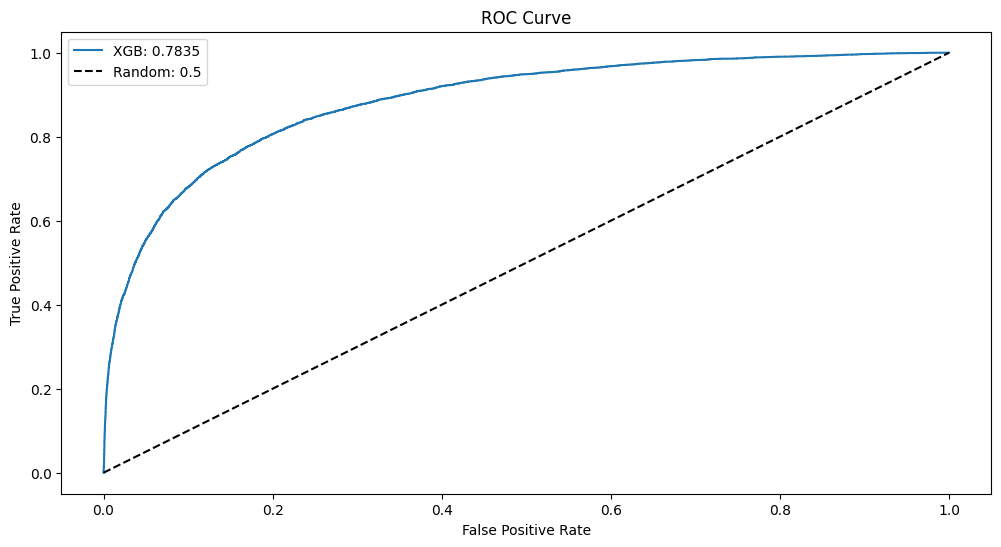

In [23]:
plt.figure(figsize = (12,6), linewidth = 2)

plt.plot(false, true, label = 'XGB: ' + str(round(roc, 4)))


plt.plot([0, 1], [0, 1], 'k--', label = 'Random: 0.5')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

In [27]:
_test_df = test_df.copy()
# _test_df.drop(columns=["id"], inplace=True)
_test_df = get_features(_test_df)

In [28]:
_test_df.head()

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,geo_France,geo_Germany,geo_Spain,prod_1,prod_2,prod_3,prod_4
0,586,1,23.0,2,0.00,0.0,1.0,160976.75,1,0,0,0,1,0,0
1,683,1,46.0,2,0.00,1.0,0.0,72549.27,1,0,0,1,0,0,0
2,656,1,34.0,7,0.00,1.0,0.0,138882.09,1,0,0,0,1,0,0
3,681,0,36.0,8,0.00,1.0,0.0,113931.57,1,0,0,1,0,0,0
4,752,0,38.0,10,121263.62,1.0,0.0,139431.00,0,1,0,1,0,0,0


In [29]:
predictions = grid.predict(_test_df)
submission = pd.DataFrame([])
submission["id"] = test_df["id"]
submission["Exited"] = predictions
submission.to_csv("xgb.csv", index=False)